<a href="https://colab.research.google.com/github/SauloHenriqueAguiar/LSTMSerieTemporalESP32/blob/main/SerieTemporalClimaLSTMparaMicrocontroladores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Série Temporal de parametros climáticos para Microcontrolador




Este projeto é o treino e geração de arquivo de um modelo de série temporal LSTM compatível com o Edge TPU( [Coral devices](https://coral.ai/products/)), e outros microcontroladores.

Esse notebook foi baseado em [Keras timeseries forecasting tutorial](https://keras.io/examples/timeseries/timeseries_weather_forecasting/). Acabamos de adicionar código para quantizar o modelo com o TensorFlow Lite e compilá-lo para o Edge TPU ou outro microcontrolador






## Importar as bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
assert float(tf.__version__[:3]) >= 2.3

In [3]:
# Define paths para  modelos de arquivos
#import os
#MODELS_DIR = 'models/'
#if not os.path.exists(MODELS_DIR):
#    os.mkdir(MODELS_DIR)
#MODEL_TF = MODELS_DIR + 'model_checkpoint.h5'
#MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'weather_forecast.tflite'
#MODEL_TFLITE = MODELS_DIR + 'weather_forecast_quant.tflite'
#MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

## Preparar o conjunto de dados climáticos

Estaremos usando o conjunto de dados Jena Climate registrado pelo[Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/).
O conjunto de dados consiste em 14 recursos, como temperatura, pressão, umidade etc., registrados uma vez por
10 minutos.

**Local**: Estação Meteorológica, Instituto Max Planck de Biogeoquímica
em Jena, Alemanha

**Prazo considerado**: 10 de janeiro de 2009 - 31 de dezembro de 2016


A tabela abaixo mostra os nomes das colunas, seus formatos de valor e sua descrição.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

In [4]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

13582336/13568290 [==============================] - 0s 0us/step


### Visualize os dados


Para nos dar uma noção dos dados com os quais estamos trabalhando, cada recurso foi plotado abaixo. Isso mostra o padrão distinto de cada recurso no período de 2009 a 2016. Também mostra onde as anomalias estão presentes, que serão abordadas durante a normalização.

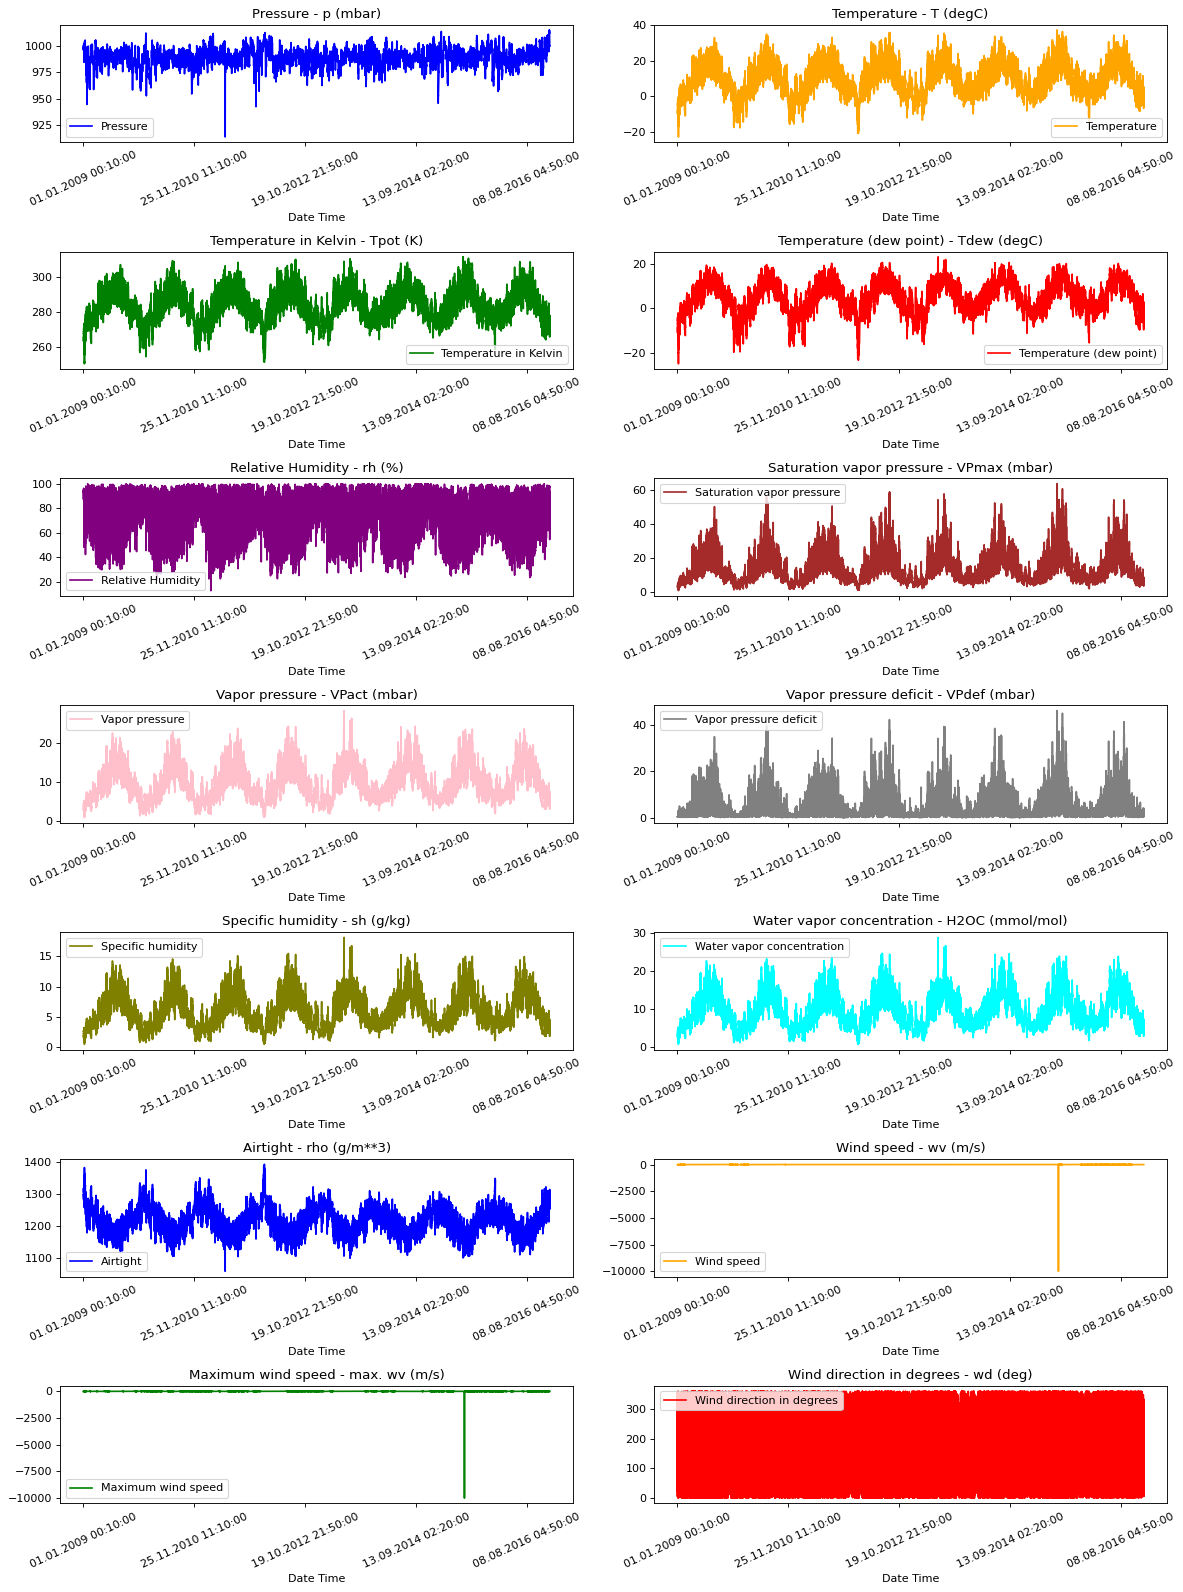

In [5]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"

def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

Este mapa de calor mostra a correlação entre diferentes recursos.

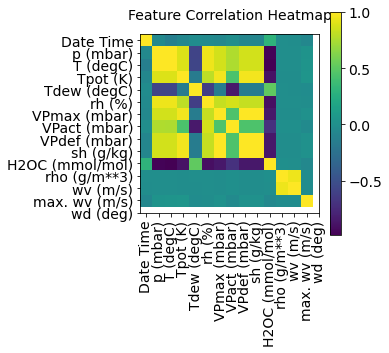

In [6]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()

show_heatmap(df)

### Pré-processar o conjunto de dados

Aqui estamos escolhendo ~ 300.000 pontos de dados para treinamento. A observação é registrada a cada 10 minutos, ou seja, 6 vezes por hora. Reamostraremos um ponto por hora, já que nenhuma mudança drástica é esperada em 60 minutos. Fazemos isso por meio do argumento sampling_rate no utilitário timeseries_dataset_from_array.

Estamos rastreando dados dos últimos 720 timestamps (720/6=120 horas). Esses dados serão usados ​​para prever a temperatura após 72 registros de data e hora (72/6=12 horas).

Como cada recurso tem valores com intervalos variados, fazemos a normalização para limitar os valores dos recursos a um intervalo de [0, 1] antes de treinar uma rede neural. Fazemos isso subtraindo a média e dividindo pelo desvio padrão de cada recurso.

71,5% dos dados serão usados ​​para treinar o modelo, ou seja, 300.693 linhas. split_fraction pode ser alterado para alterar essa porcentagem.

O modelo mostra dados para os primeiros 5 dias, ou seja, 720 observações, que são amostradas a cada hora. A temperatura após 72 (12 horas * 6 observações por hora) de observação será usada como um rótulo.

In [7]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

Podemos ver no mapa de calor de correlação, alguns parâmetros como Umidade Relativa e Umidade Específica são redundantes. Portanto, usaremos recursos selecionados, não todos.

In [8]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


### Dividir o conjunto de dados de treinamento e validação

Os rótulos do conjunto de dados de treinamento começam na 792ª observação (720 + 72).

In [9]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]
print('training size:', len(x_train))

sequence_length = int(past / step)
print('window size:', sequence_length)

training size: 300693
window size: 120


A função timeseries_dataset_from_array recebe uma sequência de pontos de dados coletados em intervalos iguais, juntamente com parâmetros de séries temporais, como comprimento das sequências/janelas, espaçamento entre duas sequências/janelas, etc., para produzir lotes de entradas e destinos de sub-séries temporais amostrado da série temporal principal.

In [10]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

O conjunto de dados de validação não deve conter as últimas 792 linhas, pois não teremos dados de rótulo para esses registros, portanto, 792 devem ser subtraídos do final dos dados.

O conjunto de dados do rótulo de validação deve começar em 792 após train_split, portanto, devemos adicionar passado + futuro (792) a label_start..

In [11]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


A forma de entrada é o batch_size definido acima, a duração da sequência (120 horas) e os 7 recursos selecionados.

Quando convertermos o modelo para o Edge TPU, teremos que alterar esse tamanho de lote para 1 para compatibilidade do compilador.

## Construir e treinar o modelo LSTM

In [12]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


Usaremos o retorno de chamada ModelCheckpoint para salvar regularmente os pontos de verificação e o retorno de chamada EarlyStopping para interromper o treinamento quando a perda de validação não estiver mais melhorando.

In [13]:
epochs = 10

In [27]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.1028
Epoch 00001: val_loss improved from inf to 0.13665, saving model to model_checkpoint.h5
1172/1172 [==============================] - 61s 52ms/step - loss: 0.1027 - val_loss: 0.1367
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1016
Epoch 00002: val_loss improved from 0.13665 to 0.12984, saving model to model_checkpoint.h5
1172/1172 [==============================] - 68s 58ms/step - loss: 0.1016 - val_loss: 0.1298
Epoch 3/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.1009
Epoch 00003: val_loss improved from 0.12984 to 0.12748, saving model to model_checkpoint.h5
1172/1172 [==============================] - 63s 54ms/step - loss: 0.1009 - val_loss: 0.1275
Epoch 4/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1022
Epoch 00004: val_loss improved from 0.12748 to 0.11974, saving model to model_checkpoint.h5
1172/1172 [==============================

In [ ]:
model

Podemos visualizar a perda com a função abaixo. Após um ponto, a perda para de diminuir.

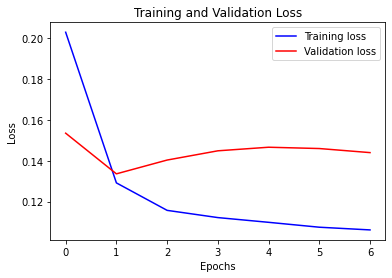

Final val loss:  [0.15345172584056854, 0.1335470974445343, 0.14030003547668457, 0.1448230892419815, 0.14657656848430634, 0.1459367573261261, 0.1439417451620102]


In [15]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print("Final val loss: ", val_loss)

visualize_loss(history, "Training and Validation Loss")

## Plota algumas previsões 

algumas das previsões de um novo conjunto de testes. Criei um novo conjunto de dados de teste (mesmo que tenha os mesmos dados que o conjunto de validação) porque quero um tamanho de lote de apenas 1 (isso é necessário quando compilamos para o Edge TPU ou outro microcontrolador). Também definimos o sequence_stride para algo maior que o comprimento da sequência/janela, para que nossas amostras de teste não sejam quase idênticas.

In [16]:
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sequence_stride=int(sequence_length * 6),
    sampling_rate=step,
    batch_size=1,
)

prediction: [0.24940275]
truth: [0.2258011]


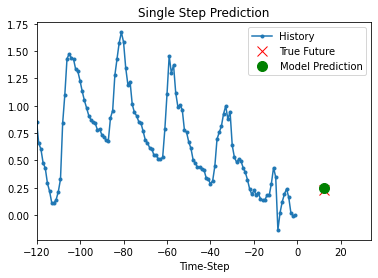

prediction: [0.28639573]
truth: [0.43425469]


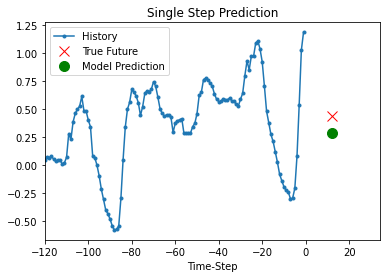

prediction: [0.43544146]
truth: [0.03356057]


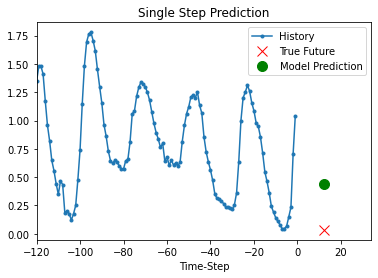

prediction: [0.2993751]
truth: [0.98434055]


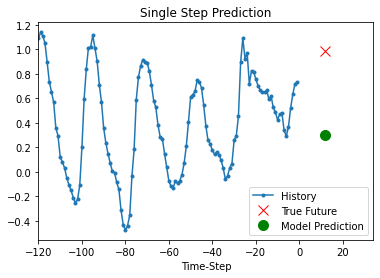

prediction: [0.46067205]
truth: [0.41109318]


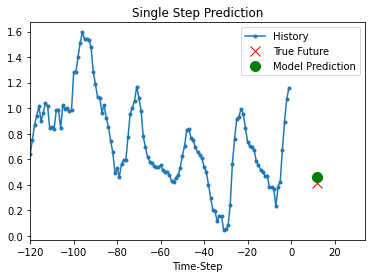

In [17]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for x, y in dataset_test.take(5):
    prediction = model.predict(x)
    prediction = prediction[0]
    print('prediction:', prediction)
    print('truth:', y[0].numpy())
    show_plot(
        [x[0][:, 1].numpy(), y[0], prediction],
        12,
        "Single Step Prediction",
    )

## Converter para TensorFlow Lite

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

with open('weather_forecast.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpvxpszkrs/assets


INFO:tensorflow:Assets written to: /tmp/tmpvxpszkrs/assets


Isso nos dá uma versão básica do TF Lite, que pode ser útil para benchmarks, mas precisamos dela totalmente quantizada para compatibilidade com o Edge TPU, Arduino,ESP32 ou outro microcontrolador

### Criando versão quantizada

Primeiro, precisamos atualizar a forma de entrada do modelo para um tamanho fixo, conforme ditado pelos requisitos do modelo Edge TPU ou outro microcontrolador [Edge TPU model requirements](https://coral.ai/docs/edgetpu/models-intro/#model-requirements).

In [19]:
batch_size = 1
model.input.set_shape((batch_size,) + model.input.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(1, 120, 7)]             0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Nosso conjunto de dados representativo é o mesmo que o conjunto de dados de treinamento,
# mas o tamanho do lote agora deve ser 1
dataset_repr = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

def representative_data_gen():
  # To ensure full coverage of possible inputs, we use the whole train set
  for input_data, _ in dataset_repr.take(int(len(x_train))):
    input_data = tf.cast(input_data, dtype=tf.float32)
    yield [input_data]

Esta parte leva vários minutos devido ao tamanho do conjunto de dados representativo:

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to int8
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model_quant = converter.convert()

with open('weather_forecast_quant.tflite', 'wb') as f:
  f.write(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmpxgcobi7r/assets


INFO:tensorflow:Assets written to: /tmp/tmpxgcobi7r/assets


### Algumas previsões do TF Lite

prediction: [0.24251606]
truth: [0.2258011]


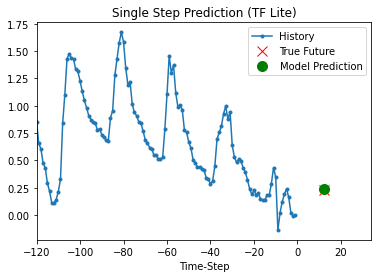

prediction: [0.26272574]
truth: [0.43425469]


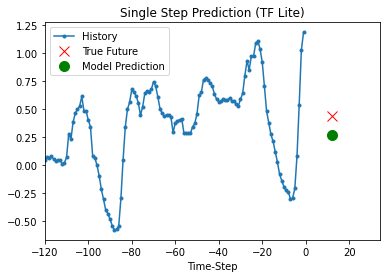

prediction: [0.42440311]
truth: [0.03356057]


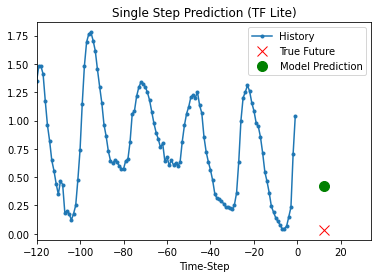

prediction: [0.28293541]
truth: [0.98434055]


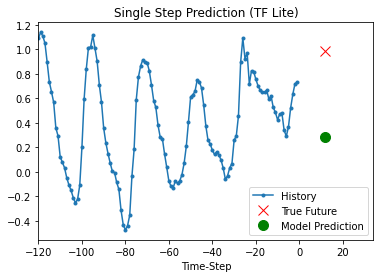

prediction: [0.46482245]
truth: [0.41109318]


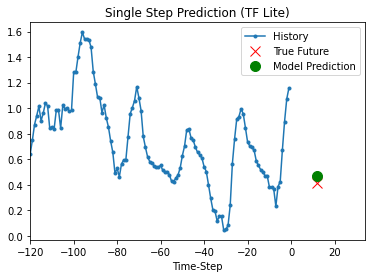

In [22]:
import numpy as np

def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()
  # As entradas para o modelo TFLite devem ser uint8, então quantizamos nossos dados de entrada.
  scale, zero_point = input_details['quantization']
  quantized_input = np.uint8(input / scale + zero_point)
  input_tensor[:, :, :] = quantized_input

def predict_weather(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # As saídas do modelo TFLite são uint8, então desquantizamos os resultados:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  return output

interpreter = tf.lite.Interpreter('weather_forecast_quant.tflite')
interpreter.allocate_tensors()

for x, y in dataset_test.take(5):
  prediction = predict_weather(interpreter, x)
  print('prediction:', prediction[0])
  print('truth:', y[0].numpy())

  show_plot(
      [x[0][:, 1].numpy(), y[0], prediction[0]],
      12,
      "Single Step Prediction (TF Lite)",
  )

Se você comparar essas previsões do modelo quantizado com aquelas que obtivemos do modelo flutuante Keras acima, elas não são muito diferentes.

## Compilar para o Edge TPU

In [23]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

! edgetpu_compiler weather_forecast_quant.tflite

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   130k      0 --:--:-- --:--:-- --:--:--  130k
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learn

Você pode encontrar o modelo compilado na janela Arquivos à esquerda, chamada weather_forecast_quant_edgetput.tflite.

#Gerar um modelo TensorFlow Lite para microcontroladores

#### modelo quantizado do TensorFlow Lite em um arquivo de origem C que pode ser carregado pelo TensorFlow Lite para microcontroladores.

In [48]:
MODEL_TFLITE = '/content/weather_forecast_quant.tflite'
MODEL_TFLITE_MICRO = '/content/model.cc'


In [49]:
#gerar modelo para microcontrolador

# Instale xxd se não estiver disponível
!apt-get update && apt-get -qq install xxd
# Converter para um arquivo de origem C, ou seja, um modelo TensorFlow Lite for Microcontrollers
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Atualizar nomes de variáveis
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:3 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubunt

In [50]:
# Imprima o arquivo de origem C
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x28, 0x00, 0x00, 0x00, 0x68, 0x01, 0x00, 0x00,
  0x28, 0x00, 0x00, 0x00, 0x10, 0x01, 0x00, 0x00, 0x90, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x64, 0x08, 0x00, 0x00, 0x14, 0x05, 0x00, 0x00,
  0xd4, 0x03, 0x00, 0x00, 0xf8, 0x02, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x64, 0x01, 0x00, 0x00, 0x1b, 0x00, 0x00, 0x00, 0x60, 0x25, 0x00, 0x00,
  0x5c, 0x25, 0x00, 0x00, 0x7c, 0x24, 0x00, 0x00, 0x20, 0x24, 0x00, 0x00,
  0xcc, 0x23, 0x00, 0x00, 0xe8, 0x22, 0x00, 0x00, 0x04, 0x22, 0x00, 0x00,
  0x20, 0x21, 0x00, 0x00, 0x3c, 0x20, 0x00, 0x00, 0xb0, 0x1f, 0x00, 0x00,
  0x4c, 0x1f, 0x00, 0x00, 0x04, 0x1e, 0x00, 0x00, 0xb8, 0x1c, 0x00, 0x00,
  0x6c, 0x1b, 0x00, 0x00, 0x20, 0x1a, 0x00, 0x00, 0xb4, 0x15, 0x00, 0x00,
  0x48, 0x